# Confidence model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
from rdkit import Chem


# Sci-kit learn
from mol2ccs.confidence_model import RFStructureConfidenceModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    roc_auc_score,
)

from utils import SeabornFig2Grid
import matplotlib.gridspec as gridspec

from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
warnings.simplefilter(action="ignore", category=FutureWarning)

# SettingWithCopyWarning
pd.options.mode.chained_assignment = None

# Get data

In [4]:
ccsbase_full = pd.read_parquet(
    "/Users/chloeengler/Documents/Tools/ccs-prediction/data (1)/ccs-prediction/ccsbase_3d.parquet",
)


metlin_full = pd.read_parquet(
    "/Users/chloeengler/Documents/Tools/ccs-prediction/data (1)/ccs-prediction/metlin_3d.parquet",
)

In [5]:
metlin_test = pd.read_parquet(
    "/Users/chloeengler/Documents/Tools/ccs-prediction/data (1)/ccs-prediction/metlin_test_3d.parquet"
)
ccsbase_test = pd.read_parquet(
    "/Users/chloeengler/Documents/Tools/ccs-prediction/data (1)/ccs-prediction/ccsbase_test_3d.parquet"
)

original_test_sets = {
    "ccsbase": ccsbase_test,
    "metlin": metlin_test,
}

In [6]:
relevant_cols = [
    "dimer",
    "source",
    "mol_type",
    "ccs_type",
    "drugtax",
    "type_dimer",
    "smiles_adduct",
]

metlin_full = metlin_full[relevant_cols]
ccsbase_full = ccsbase_full[relevant_cols]

In [7]:
predictions = {}

# Load the original test sets for each dataset
original_test_set_preds = dict(
    zip(
        [
            "ccsbase test",
            "metlin test",
        ],
        [
            "/Users/chloeengler/Documents/Tools/ccs-prediction/data (1)/ccs-prediction-outputs/final-experiments-paper/mol2ccs/ccsbase_test_3d_pred.parquet",  # 0.05% error is necessary because the model is pretty good
            "/Users/chloeengler/Documents/Tools/ccs-prediction/data (1)/ccs-prediction-outputs/final-experiments-paper/mol2ccs/metlin_test_3d_pred.parquet",
        ],
    )
)

# Load the predictions for the test sets for the models trained on the other dataset
for name, path in zip(
    [
        "ccsbase predictions from metlin",
        "metlin predictions from ccsbase",
    ],
    [
        "/Users/chloeengler/Documents/Tools/ccs-prediction/data (1)/ccs-prediction-outputs/final-experiments-paper/mol2ccs/ccsbase_3d_pred.parquet",  # 5% error -> good
        "/Users/chloeengler/Documents/Tools/ccs-prediction/data (1)/ccs-prediction-outputs/final-experiments-paper/mol2ccs/metlin_3d_pred.parquet",  # 5% error -> good
    ],
):
    preds = pd.read_parquet(path)

    # Get all molecular information
    preds["smiles_adduct"] = preds["smiles"] + "_" + preds["adduct"]
    if "ccsbase" in path:
        preds = preds.merge(ccsbase_full, on="smiles_adduct", how="left")
    else:
        preds = preds.merge(metlin_full, on="smiles_adduct", how="left")

    # Split the data into train, test, and validation
    original_test_set = original_test_sets[name.split(" ")[0]]
    test = preds[preds.smiles_adduct.isin(list(original_test_set.smiles_adduct))]
    train = preds[~preds.smiles_adduct.isin(list(test.smiles_adduct))]
    train_smiles = train.smiles.unique()
    train_smiles, val_smiles = train_test_split(
        train_smiles, test_size=0.1, random_state=42
    )
    val = train[train.smiles.isin(val_smiles)]
    train = train[train.smiles.isin(train_smiles)]

    # ensure that no smiles are in both train and test
    assert len(set(train.smiles).intersection(set(test.smiles))) == 0
    assert len(set(val.smiles).intersection(set(test.smiles))) == 0
    assert len(set(train.smiles).intersection(set(val.smiles))) == 0

    predictions[name] = {
        "train": train,
        "test": test,
        "val": val,
    }

# Get model

In [8]:
all_confidence_preds = {}
all_confidence_preds_val = {}
all_models_dict = {}
num_samples = [0, 5, 10, 25, 50, 100, 1000]

# Train the confidence model for each dataset
for num_sample in num_samples:
    confidence_preds = {}
    models_dict = {}
    confidence_preds_val = {}
    for prediction_file in tqdm(predictions):
        print(f"Training model for {prediction_file}")

        # Get test set and in-domain training set
        test = predictions[prediction_file]["test"]
        val = predictions[prediction_file]["val"]
        in_domain_train = predictions[prediction_file]["train"]

        # get training set
        train_name = prediction_file.split(" ")[-1]
        train_name = str(train_name) + " test"
        train = pd.read_parquet(original_test_set_preds[train_name])
        train["smiles_adduct"] = train["smiles"] + "_" + train["adduct"]
        if train_name == "ccsbase test":
            train = train.merge(ccsbase_full, on="smiles_adduct", how="left")
        elif train_name == "metlin test":
            train = train.merge(metlin_full, on="smiles_adduct", how="left")
        else:
            raise ValueError("Unknown training set")

        # Sample from in domain training set
        in_domain_sample = in_domain_train.sample(num_sample, random_state=42)
        train = pd.concat([train, in_domain_sample])

        error_threshold = 0.05  # 5% error

        # initialize model
        model = RFStructureConfidenceModel(
            estimator_type="classifier",
            target_type="binary_error",
        )

        # fit model
        feature_df = model.fit(
            train,
            hpo_params={
                "n_estimators": [50, 100, 200, 400],
                "max_depth": [None, 10, 20, 50],
                "min_samples_split": [2, 5, 20],
            },
            error_threshold=error_threshold,
        )

        # predict confidence
        test["confs"] = model.predict_confidence(test)

        # calculate errors
        test["errors"] = abs(test["ccs"] - test["pred_ccs"])

        # predict confidence on validation set
        val["confs"] = model.predict_confidence(val)
        val["errors"] = abs(val["ccs"] - val["pred_ccs"])

        # save results
        confidence_preds[prediction_file] = test.copy()
        confidence_preds_val[prediction_file] = val.copy()
        models_dict[prediction_file] = model

    all_confidence_preds[num_sample] = confidence_preds
    all_confidence_preds_val[num_sample] = confidence_preds_val
    all_models_dict[num_sample] = models_dict

  0%|          | 0/2 [00:00<?, ?it/s]

Training model for ccsbase predictions from metlin

            Number of labels: True     9761
False     891
Name: count, dtype: int64
            % of True labels: 91.64%
            % of False labels: 8.36%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [00:24<00:24, 24.07s/it]

Training model for metlin predictions from ccsbase

            Number of labels: True     1624
False     206
Name: count, dtype: int64
            % of True labels: 88.74%
            % of False labels: 11.26%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]

Training model for ccsbase predictions from metlin

            Number of labels: True     9764
False     893
Name: count, dtype: int64
            % of True labels: 91.62%
            % of False labels: 8.38%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [00:14<00:14, 14.70s/it]

Training model for metlin predictions from ccsbase

            Number of labels: True     1628
False     207
Name: count, dtype: int64
            % of True labels: 88.72%
            % of False labels: 11.28%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]

Training model for ccsbase predictions from metlin

            Number of labels: True     9766
False     896
Name: count, dtype: int64
            % of True labels: 91.60%
            % of False labels: 8.40%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [00:15<00:15, 15.63s/it]

Training model for metlin predictions from ccsbase

            Number of labels: True     1632
False     208
Name: count, dtype: int64
            % of True labels: 88.70%
            % of False labels: 11.30%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]

Training model for ccsbase predictions from metlin

            Number of labels: True     9771
False     906
Name: count, dtype: int64
            % of True labels: 91.51%
            % of False labels: 8.49%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [00:14<00:14, 14.71s/it]

Training model for metlin predictions from ccsbase

            Number of labels: True     1643
False     212
Name: count, dtype: int64
            % of True labels: 88.57%
            % of False labels: 11.43%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]

Training model for ccsbase predictions from metlin

            Number of labels: True     9782
False     920
Name: count, dtype: int64
            % of True labels: 91.40%
            % of False labels: 8.60%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [00:16<00:16, 16.85s/it]

Training model for metlin predictions from ccsbase

            Number of labels: True     1663
False     217
Name: count, dtype: int64
            % of True labels: 88.46%
            % of False labels: 11.54%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]

Training model for ccsbase predictions from metlin

            Number of labels: True     9801
False     951
Name: count, dtype: int64
            % of True labels: 91.16%
            % of False labels: 8.84%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [00:17<00:17, 17.38s/it]

Training model for metlin predictions from ccsbase

            Number of labels: True     1697
False     233
Name: count, dtype: int64
            % of True labels: 87.93%
            % of False labels: 12.07%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
  0%|          | 0/2 [00:00<?, ?it/s]

Training model for ccsbase predictions from metlin

            Number of labels: True     10178
False     1474
Name: count, dtype: int64
            % of True labels: 87.35%
            % of False labels: 12.65%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 50%|█████     | 1/2 [00:20<00:20, 20.55s/it]

Training model for metlin predictions from ccsbase

            Number of labels: True     2372
False     458
Name: count, dtype: int64
            % of True labels: 83.82%
            % of False labels: 16.18%
            


/Users/chloeengler/Documents/Tools/ccs-prediction/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 2/2 [00:34<00:00, 17.04s/it]


# Get thresholds

In [9]:
#  Iterate through the predictions again and calculate precision and recall for the different thresholds

all_cutoffs_val = {}

# Calculate precision and recall for the different thresholds
for num_sample in num_samples:
    cutoffs = defaultdict(dict)
    for prediction_file in all_confidence_preds_val[num_sample]:
        if "from" not in prediction_file:
            print(f"Skipping {prediction_file} because preds are not good")
            continue

        # get the predictions
        prediction_df = all_confidence_preds_val[num_sample][prediction_file]

        for threshold in range(0, 10, 1):
            threshold /= 10

            # if y is less than 5% of the true CCS, set to True, else False
            y = prediction_df["ccs"] - prediction_df["pred_ccs"]
            y = y.abs()
            labels = y < (error_threshold * prediction_df["ccs"])

            # if the confidence is greater than the threshold, set to True, else False
            pred_labels = prediction_df["confs"] >= threshold

            # change labels and pred_labels to 0 and 1 from True and False
            labels = labels.astype(int)
            pred_labels = pred_labels.astype(int)

            # calculate precision and recall
            precision = precision_score(labels, pred_labels, zero_division=0)
            recall = recall_score(labels, pred_labels)
            f1 = f1_score(labels, pred_labels)
            accuracy = accuracy_score(labels, pred_labels)
            auc_roc = roc_auc_score(labels, pred_labels)
            dataset_percentage = (pred_labels == 1).mean()

            # save results
            cutoffs[prediction_file][threshold] = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "accuracy": accuracy,
                "auc_roc": auc_roc,
                "labels": labels,
                "pred_labels": pred_labels,
                "dataset_percentage": dataset_percentage,
            }

    all_cutoffs_val[num_sample] = cutoffs

In [10]:
all_thresholds_df = {}

# Get the threshold where recall is greater than precision
for num_sample in num_samples:
    threshold_df = {}
    for i, prediction_file in enumerate(all_cutoffs_val[num_sample]):

        # Get the cutoffs
        cutoffs_df = pd.DataFrame(all_cutoffs_val[num_sample][prediction_file]).T.iloc[
            1:
        ]

        # Get last cutoff where recall is > than precision
        cutoffs_df["recall_precision_diff"] = (
            cutoffs_df["recall"] - cutoffs_df["precision"]
        )
        current_threshold = cutoffs_df[cutoffs_df["recall_precision_diff"] <= 0].index[
            0
        ]
        current_threshold = current_threshold - 0.1
        threshold_df[prediction_file] = current_threshold

    all_thresholds_df[num_sample] = threshold_df

# Look at distributions of conf scores

In [11]:
name_style = {
    "ccsbase predictions from metlin": "METLIN-CCS (train) CCSBase (test)",
    "metlin predictions from ccsbase": "CCSBase (train) METLIN-CCS (test)",
}

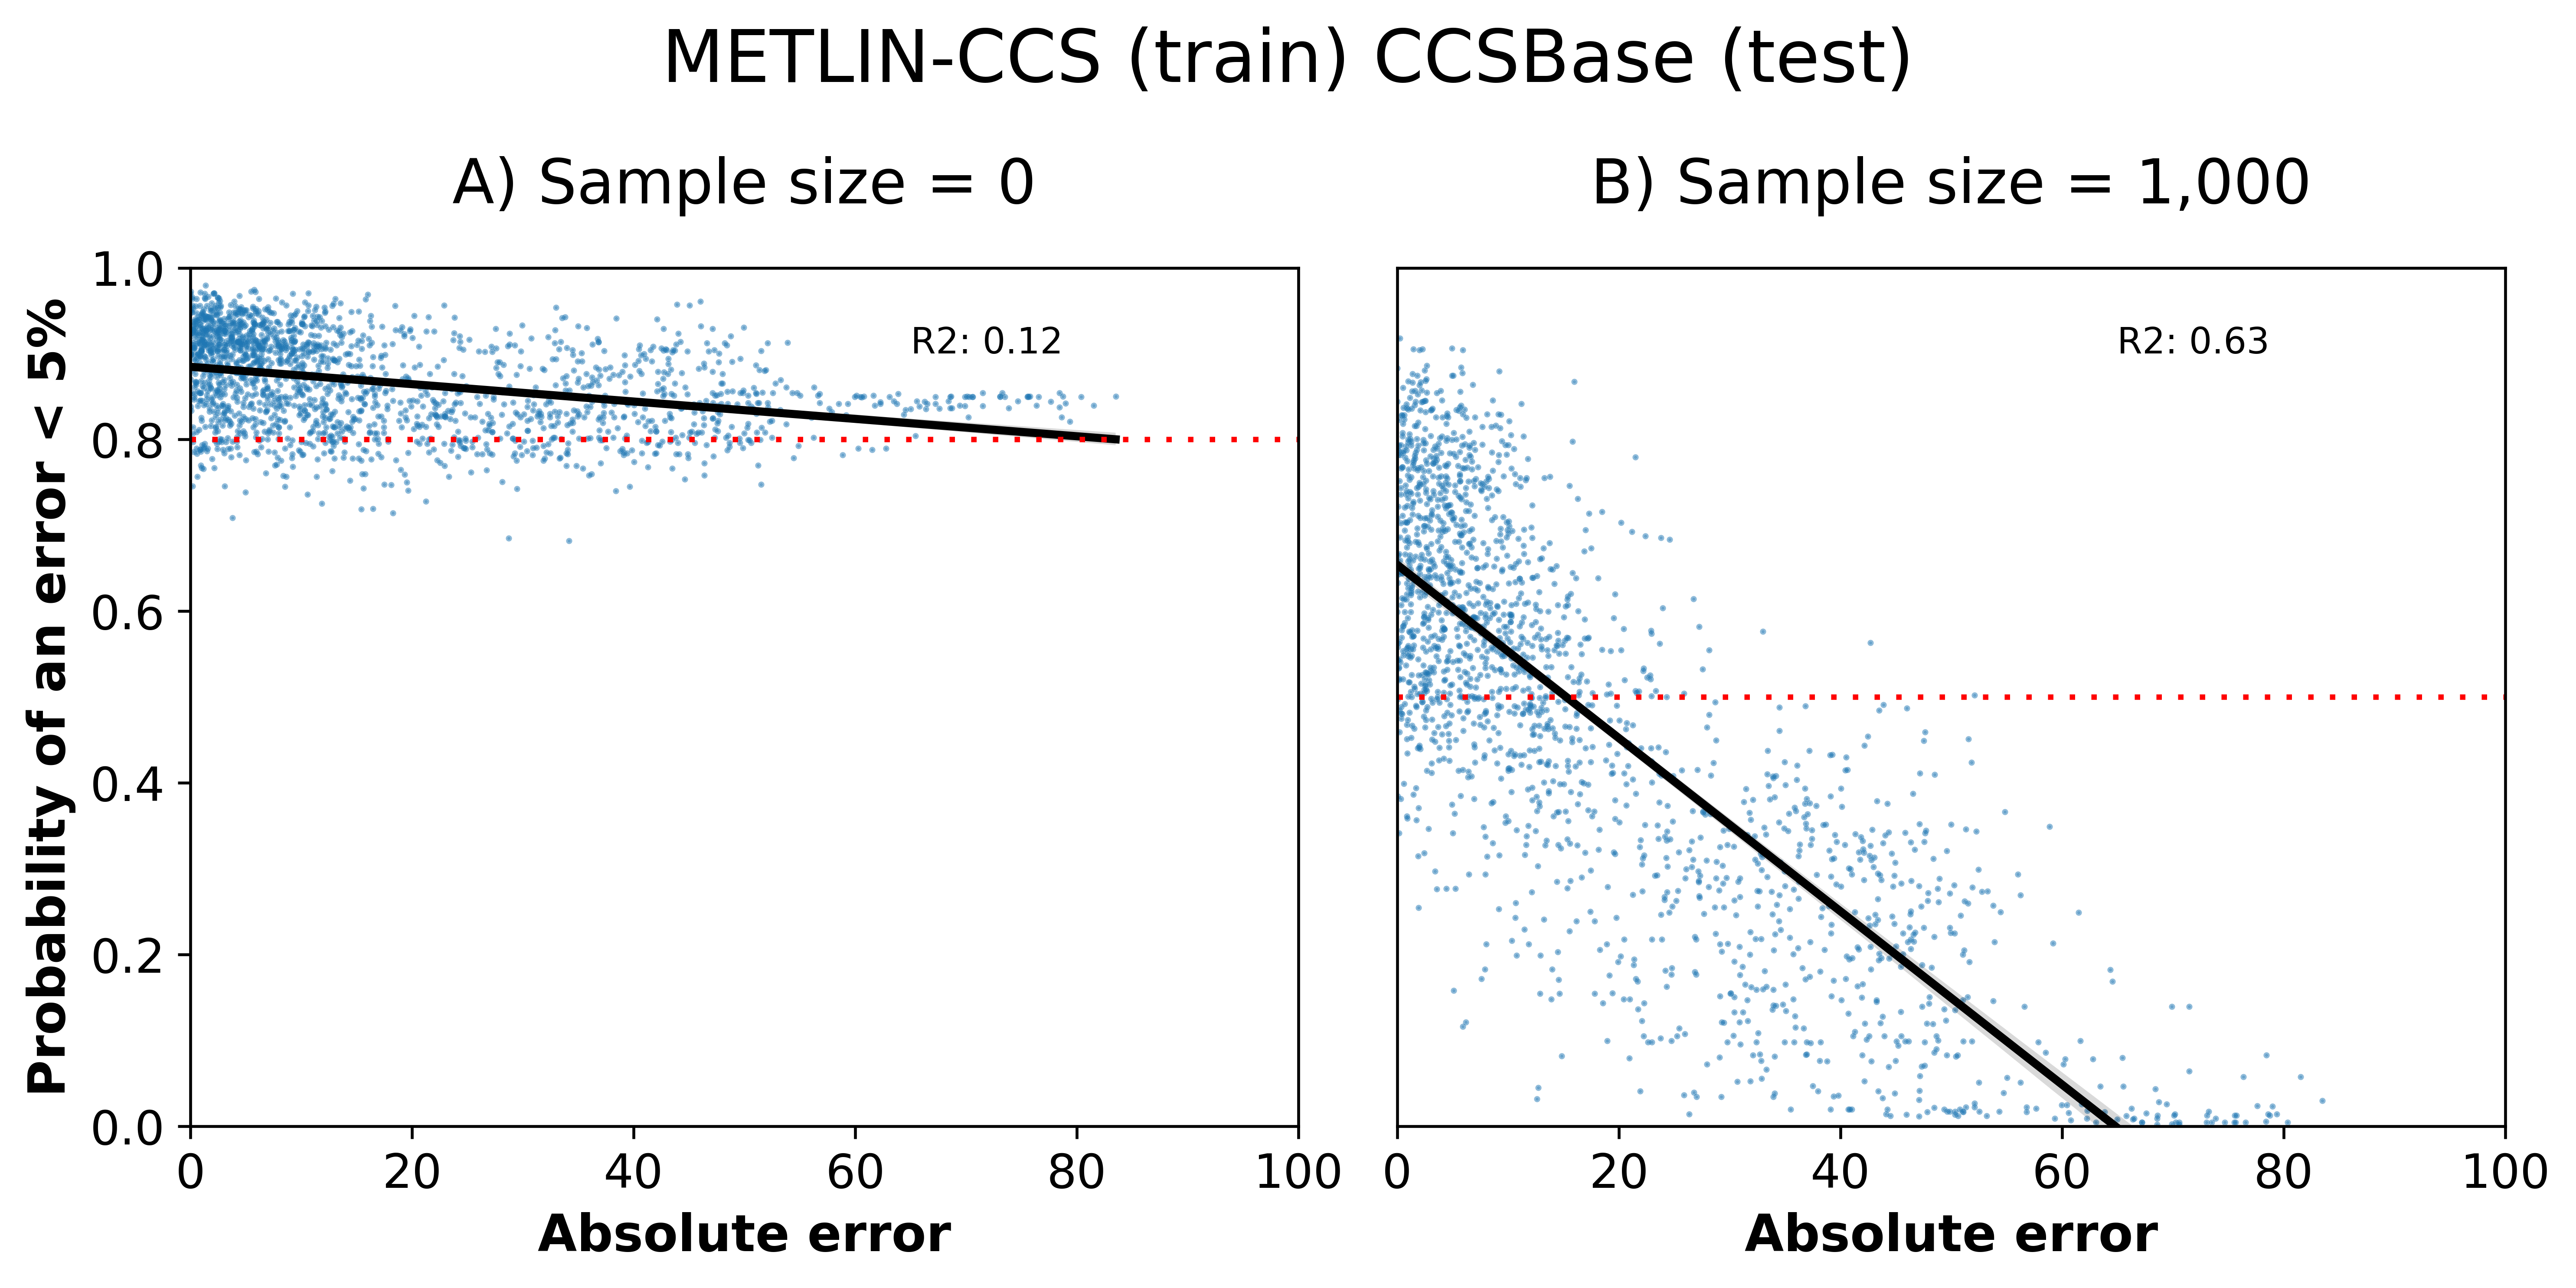

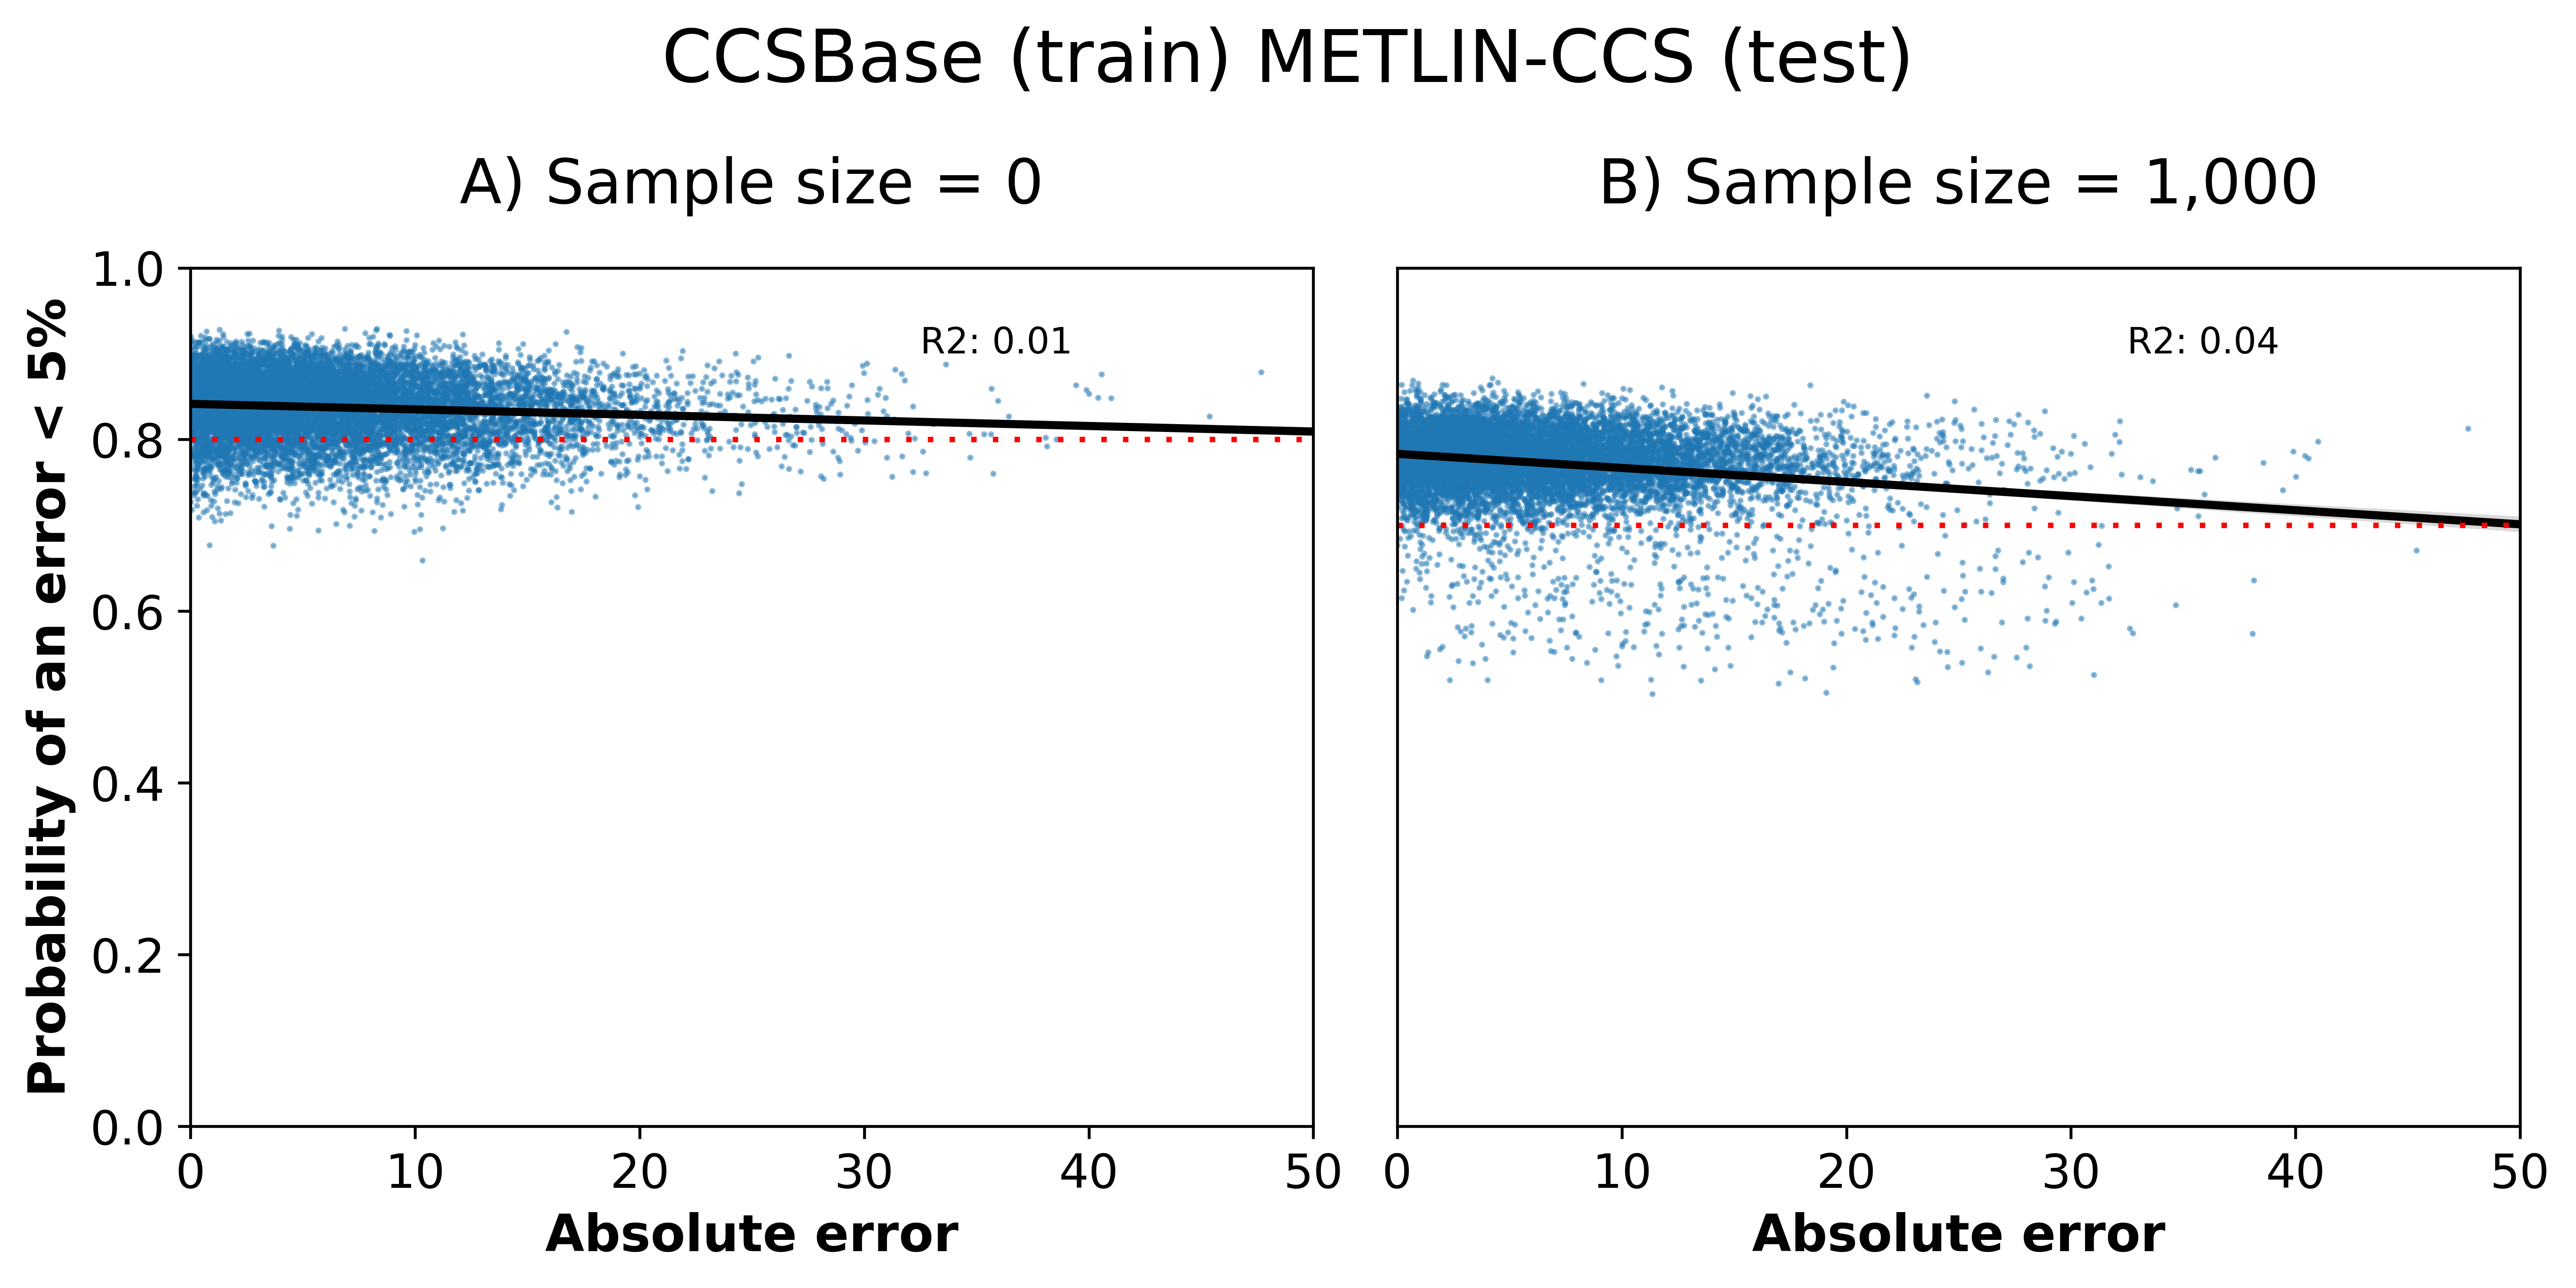

In [12]:
# Make a 2x2 plot of the results with a regression line

for j, prediction_file in enumerate(all_confidence_preds[0]):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=600)
    for i, sample_size in enumerate([0, 1000]):
        prediction_df = all_confidence_preds[sample_size][prediction_file]

        size_factor = 0.5

        # regression plot
        sns.regplot(
            x="errors",
            y="confs",
            data=prediction_df,
            scatter_kws={"s": size_factor, "alpha": 0.5},
            line_kws={"color": "black"},
            ax=axs[i],
        )

        sample_string = "{:,}".format(sample_size)
        if i == 0:
            title = f"A) Sample size = {sample_string}"
        else:
            title = f"B) Sample size = {sample_string}"

        axs[i].set_title(title, fontsize=17, y=1.05)
        axs[i].set_xlabel("Absolute error", fontsize=14, fontweight="bold")
        plt.suptitle(name_style[prediction_file], size=20)

        # show only if it's the first column
        if i % 2 == 0:
            axs[i].set_ylabel(
                "Probability of an error < 5%", fontweight="bold", fontsize=14
            )
        else:
            axs[i].set_ylabel("")
            axs[i].set_yticks([])

        # Axes limits
        if "test" in prediction_file:
            axs[i].set_xlim(0, 40)

        elif "ccsbase predictions from metlin" in prediction_file:
            axs[i].set_xlim(0, 100)
        else:
            axs[i].set_xlim(0, 50)

        # larger ticks x and y
        axs[i].tick_params(axis="both", which="major", labelsize=13)

        # calculate r2 and plot it
        r2 = prediction_df["confs"].corr(prediction_df["errors"]) ** 2
        axs[i].text(
            0.65,
            0.90,
            f"R2: {r2:.2f}",
            fontsize=10,
            transform=axs[i].transAxes,
            color="black",
        )

        # add a horizonal line on 0.7
        current_threshold = all_thresholds_df[sample_size][prediction_file]
        axs[i].axhline(y=current_threshold, color="r", linestyle=(0, (1, 3)))

        axs[i].set_ylim(0, 1)

    plt.tight_layout()

    # save
    # plt.savefig("confidence_model.png", dpi=600)

    plt.show()

What you see is that the first column (when we trained on one database, and predict on the other), the correlation is low. However, when we add a small amount of data in the domain of the test set (scaffold disjoint from the test set) to the confidence model training set (right column). This increase is more significant for the model trained on METLIN-CCS. Likely because the CCSBase dataset contains new moecule types that are never seen by the confidence model if it is only trained on METLIN-CCS data. 

In [13]:
#  Iterate through the predictions again and calculate precision and recall for the different thresholds

all_cutoffs = {}

# Calculate precision and recall for the different thresholds
for num_sample in num_samples:
    cutoffs = defaultdict(dict)
    for prediction_file in all_confidence_preds[num_sample]:
        if "from" not in prediction_file:
            print(f"Skipping {prediction_file} because preds are not good")
            continue

        # get the predictions
        prediction_df = all_confidence_preds[num_sample][prediction_file]

        # iterate through the thresholds
        for threshold in range(0, 10, 1):
            threshold /= 10

            # if y is less than 5% of the true CCS, set to True, else False
            y = prediction_df["ccs"] - prediction_df["pred_ccs"]
            y = y.abs()
            labels = y < (error_threshold * prediction_df["ccs"])

            # determine if the confidence is above the threshold
            pred_labels = prediction_df["confs"] >= threshold

            # change labels and pred_labels to 0 and 1 from True and False
            labels = labels.astype(int)
            pred_labels = pred_labels.astype(int)

            # calculate precision and recall
            precision = precision_score(labels, pred_labels, zero_division=0)
            recall = recall_score(labels, pred_labels)
            f1 = f1_score(labels, pred_labels)
            accuracy = accuracy_score(labels, pred_labels)
            auc_roc = roc_auc_score(labels, pred_labels)
            dataset_percentage = (pred_labels == 1).mean()

            # save results
            cutoffs[prediction_file][threshold] = {
                "precision": precision,
                "recall": recall,
                "f1": f1,
                "accuracy": accuracy,
                "auc_roc": auc_roc,
                "labels": labels,
                "pred_labels": pred_labels,
                "dataset_percentage": dataset_percentage,
            }

    all_cutoffs[num_sample] = cutoffs

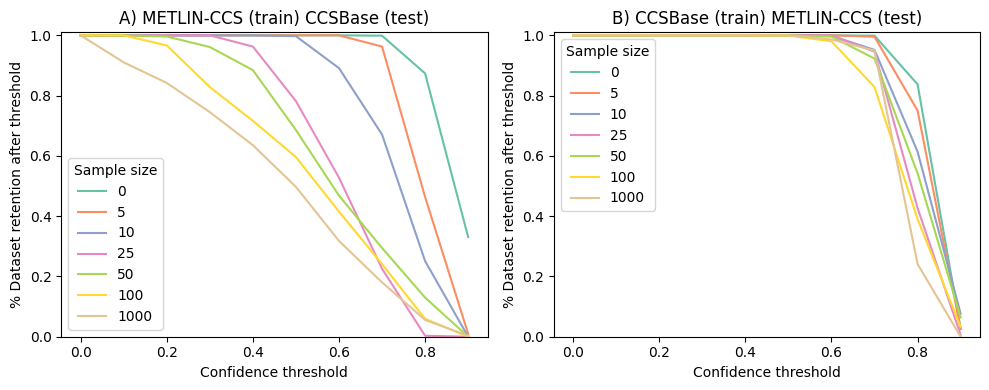

In [15]:
# Plot the metrics for the different thresholds for both datasets

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

metric_palette = sns.color_palette("Set2")

for i, prediction_file in enumerate(all_cutoffs[0]):
    for j, num_sample in enumerate(num_samples):

        cutoffs_df = pd.DataFrame(all_cutoffs[num_sample][prediction_file]).T

        sns.lineplot(
            x=cutoffs_df.index,
            y=cutoffs_df["dataset_percentage"],
            ax=axs[i],
            label=f"{num_sample}",
            # # Add points
            # marker="o",
            color=metric_palette[j],
        )

    # title
    if i == 0:
        axs[i].set_title(f"A) {name_style[prediction_file]}")
    else:
        axs[i].set_title(f"B) {name_style[prediction_file]}")
    axs[i].set_xlabel("Confidence threshold")
    axs[i].set_ylabel("% Dataset retention after threshold")
    axs[i].set_ylim(0, 1.01)

    # legend
    axs[i].legend(title="Sample size")


plt.tight_layout()

# Save with dpi 400
plt.savefig("threshold_metrics.png", dpi=400)

plt.show()

# Let's dive into the high confidence predictions

In [16]:
def calculate_metrics(df):

    mae_original = mean_absolute_error(df["ccs"], df["pred_ccs"])
    rmse_original = mean_squared_error(df["ccs"], df["pred_ccs"])
    r2_original = linregress(df["ccs"], df["pred_ccs"]).rvalue ** 2

    # median relative error in %
    median_relative_error_original = (
        (df["ccs"] - df["pred_ccs"]).abs() / df["ccs"] * 100
    )
    median_relative_error_original = median_relative_error_original.median()

    return mae_original, rmse_original, r2_original, median_relative_error_original

In [17]:
all_high_confidence_preds = {}

all_original_metrics = {}
all_high_confidence_metrics = {}

# Calculate the metrics for the original and high confidence predictions
for num_sample in num_samples:
    high_confidence_preds = {}
    original_metrics = {}
    high_confidence_metrics = {}
    for prediction_file in tqdm(predictions):
        if "from" not in prediction_file:
            continue

        # get the predictions
        pred_df = all_confidence_preds[num_sample][prediction_file]
        current_threshold = all_thresholds_df[num_sample][prediction_file]

        # get the high confidence predictions
        high_confidence_preds[prediction_file] = pred_df[
            pred_df["confs"] >= current_threshold
        ]

        # calculate metrics
        mae_original, rmse_original, r2_original, median_relative_error_original = (
            calculate_metrics(pred_df)
        )

        # calculate metrics for high confidence predictions
        mae_high, rmse_high, r2_high, median_relative_error_high = calculate_metrics(
            high_confidence_preds[prediction_file]
        )

        # save results
        original_metrics[prediction_file] = {
            "MAE": mae_original,
            "RMSE": rmse_original,
            "R2": r2_original,
            "MRE": median_relative_error_original,
        }

        high_confidence_metrics[prediction_file] = {
            "MAE": mae_high,
            "RMSE": rmse_high,
            "R2": r2_high,
            "MRE": median_relative_error_high,
        }
    all_high_confidence_preds[num_sample] = high_confidence_preds
    all_original_metrics[num_sample] = original_metrics
    all_high_confidence_metrics[num_sample] = high_confidence_metrics

100%|██████████| 2/2 [00:00<00:00, 444.24it/s]


In [18]:
def plot_scatter(
    pred_df,
    palette,
    title,
    original_metrics,
    high_confidence_metrics,
    legend=False,
    y_label=False,
    show_vs=True,
):

    g = sns.jointplot(
        data=pred_df,
        x=pred_df["ccs"],
        y=pred_df["pred_ccs"],
        hue="adduct",
        palette=palette,
        # add transparency to the points
        alpha=0.4,
        # size of the points
        s=200,
        legend=legend,
    )

    # Add a line to show the perfect correlation
    g.ax_joint.plot(
        [pred_df["ccs"].min(), pred_df["ccs"].max()],
        [pred_df["ccs"].min(), pred_df["ccs"].max()],
        "k--",
        lw=2,
    )

    if show_vs:
        g.ax_joint.text(
            0.65,
            0.15,
            f"""
            n={pred_df.shape[0]}
            MAE: {high_confidence_metrics['MAE']:.2f} vs. {original_metrics['MAE']:.2f}
            MRE: {high_confidence_metrics['MRE']:.2f}% vs. {original_metrics['MRE']:.2f}%
            R2: {high_confidence_metrics['R2']:.2f} vs. {original_metrics['R2']:.2f}""",
            horizontalalignment="center",
            verticalalignment="center",
            transform=g.ax_joint.transAxes,
            fontsize=7,
        )
    else:
        g.ax_joint.text(
            0.65,
            0.15,
            f"""
            n={pred_df.shape[0]}
            MAE: {high_confidence_metrics['MAE']:.2f}
            MRE: {high_confidence_metrics['MRE']:.2f}%
            R2: {high_confidence_metrics['R2']:.2f}""",
            horizontalalignment="center",
            verticalalignment="center",
            transform=g.ax_joint.transAxes,
            fontsize=7,
        )

    g.ax_joint.set_xlabel("Experimental CCS", fontweight="bold")

    if y_label:
        g.ax_joint.set_ylabel(f"Predicted CCS", fontweight="bold")
    else:
        g.ax_joint.set_ylabel("")

    # title
    g.ax_joint.set_title(title, y=1.2, fontsize=13)
    plt.setp(g.ax_joint.get_xticklabels(), rotation=0, ha="center", va="top")
    plt.setp(g.ax_joint.get_yticklabels(), rotation=0, ha="right", va="center")
    g.ax_joint.yaxis.set_tick_params(pad=10)
    g.ax_joint.xaxis.set_tick_params(pad=10)

    # set legend title
    if legend:
        g.ax_joint.get_legend().set_title(f"Adduct n={pred_df.shape[0]}")

        g.ax_joint.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)

        # legend smaller
        for text in g.ax_joint.get_legend().texts:
            text.set_fontsize(8)

    return g

<Figure size 16000x8000 with 0 Axes>

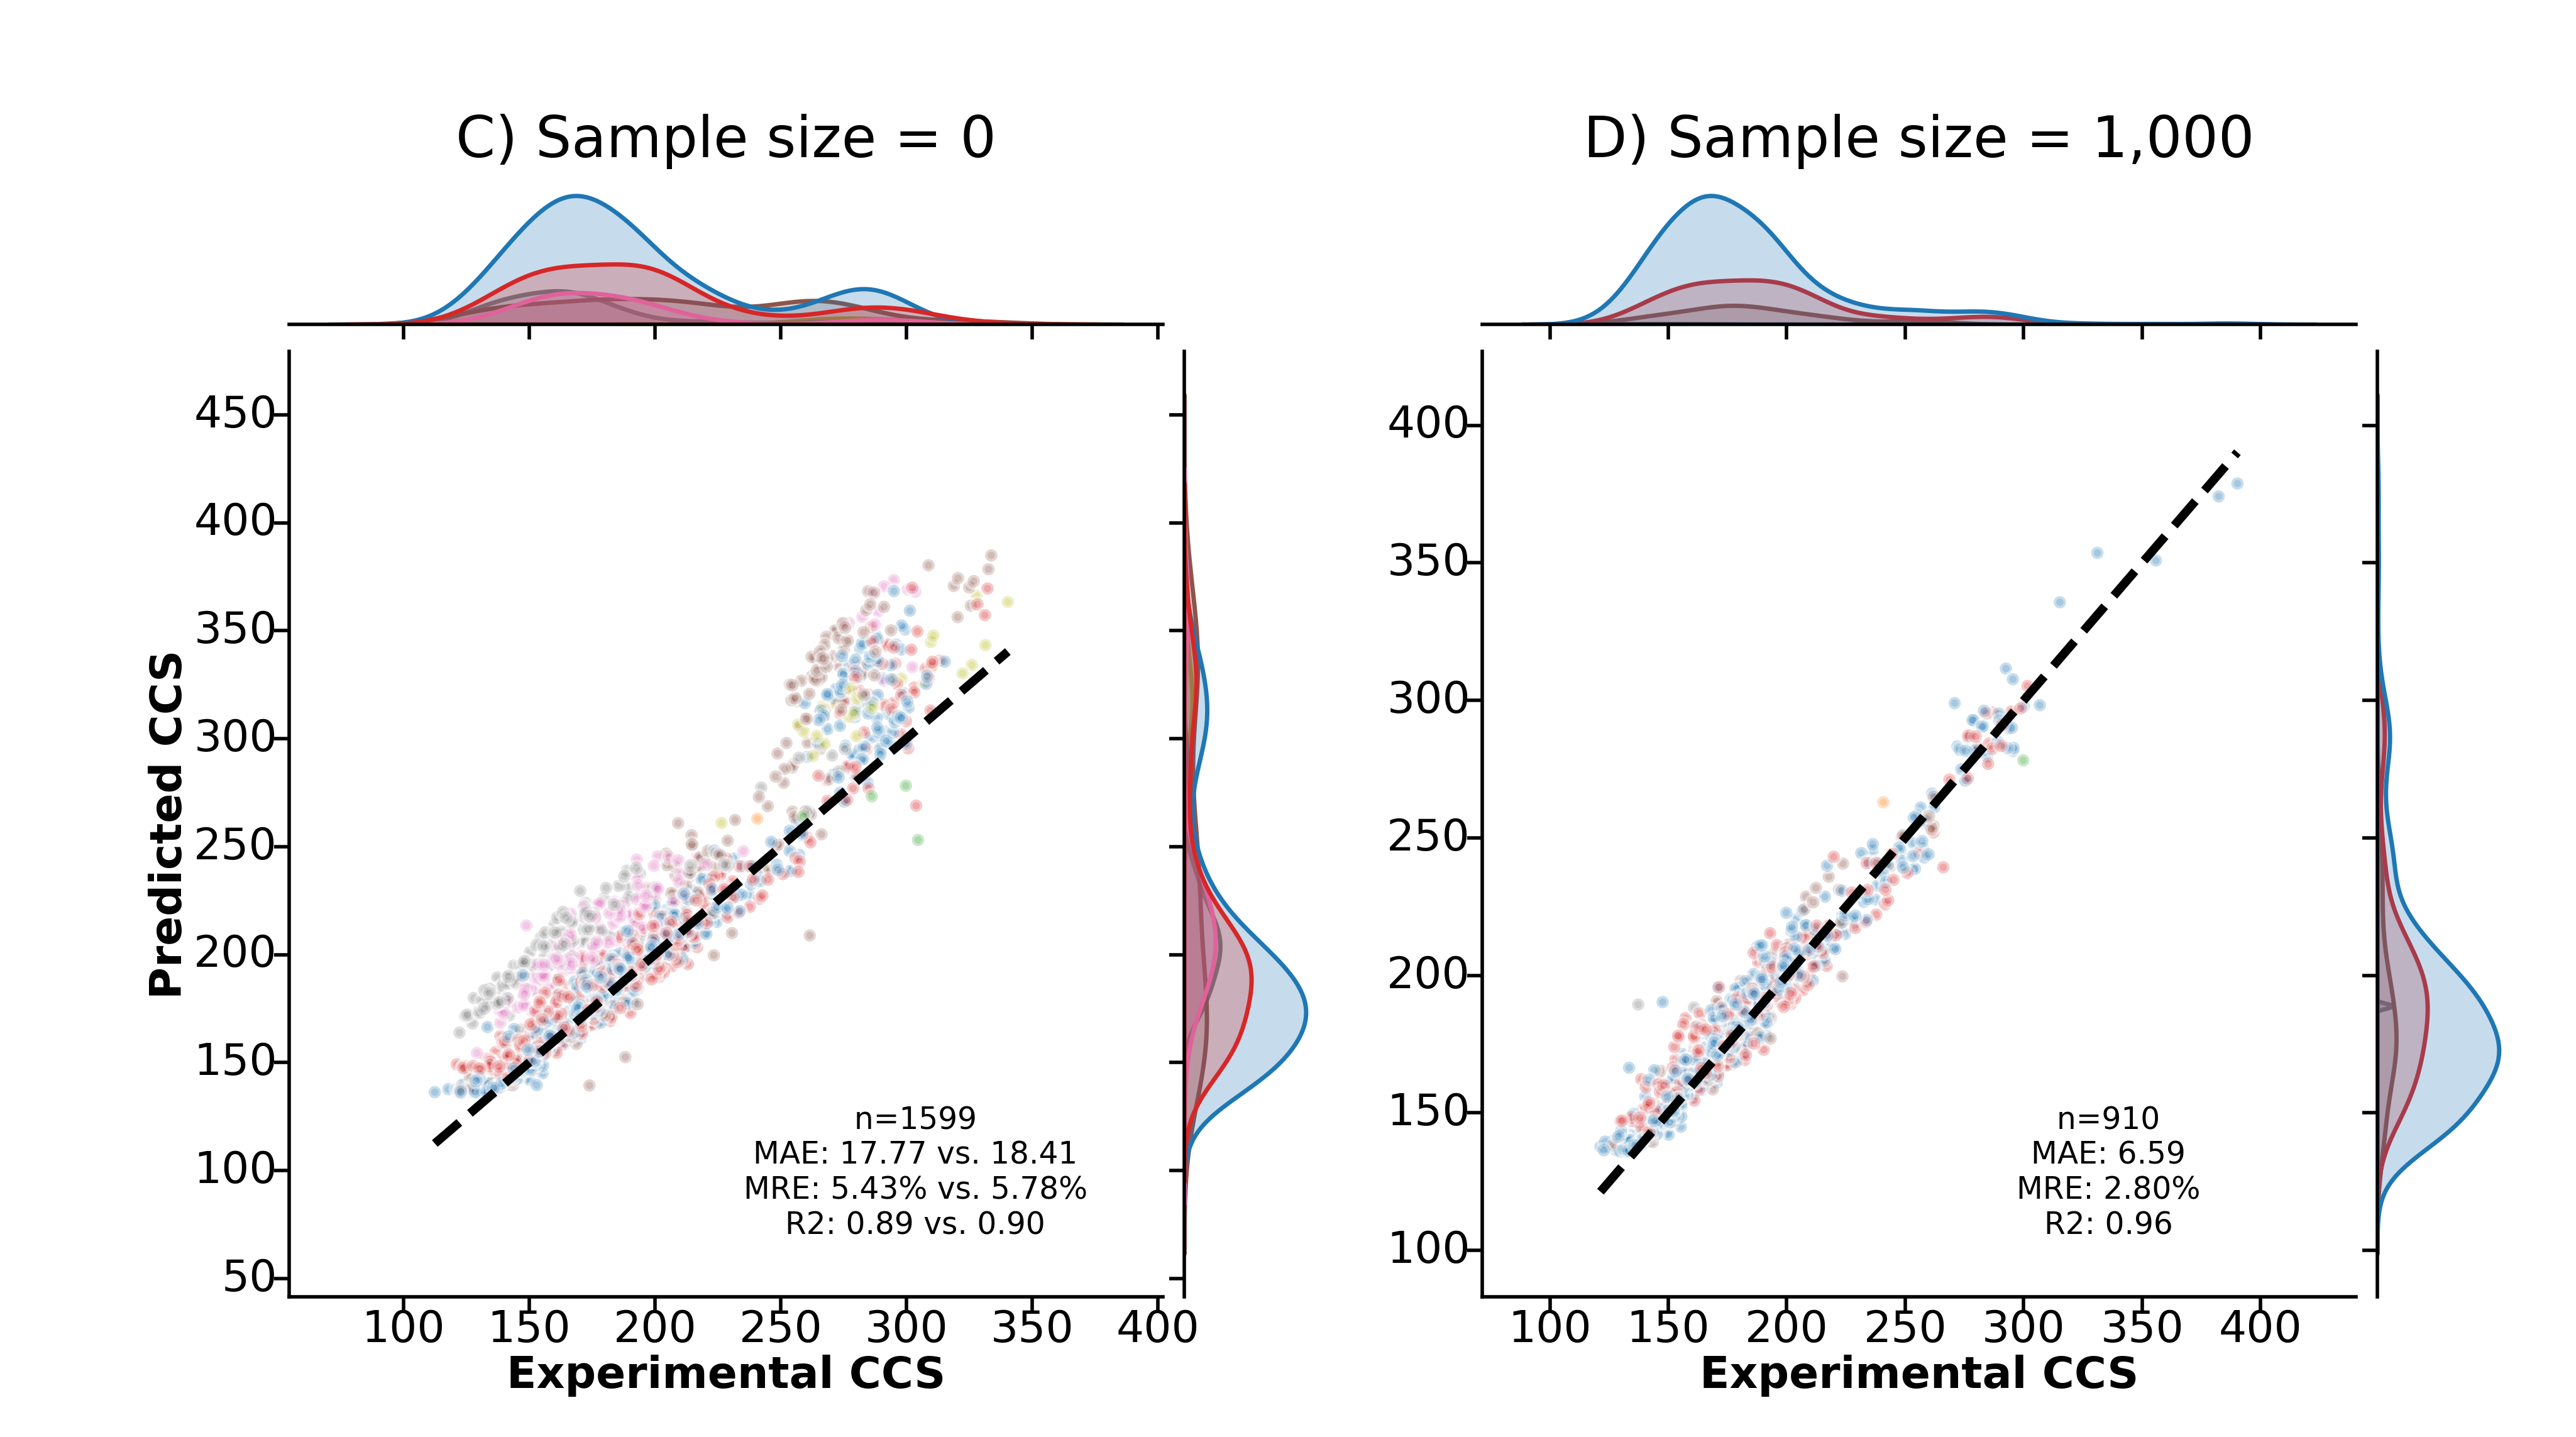

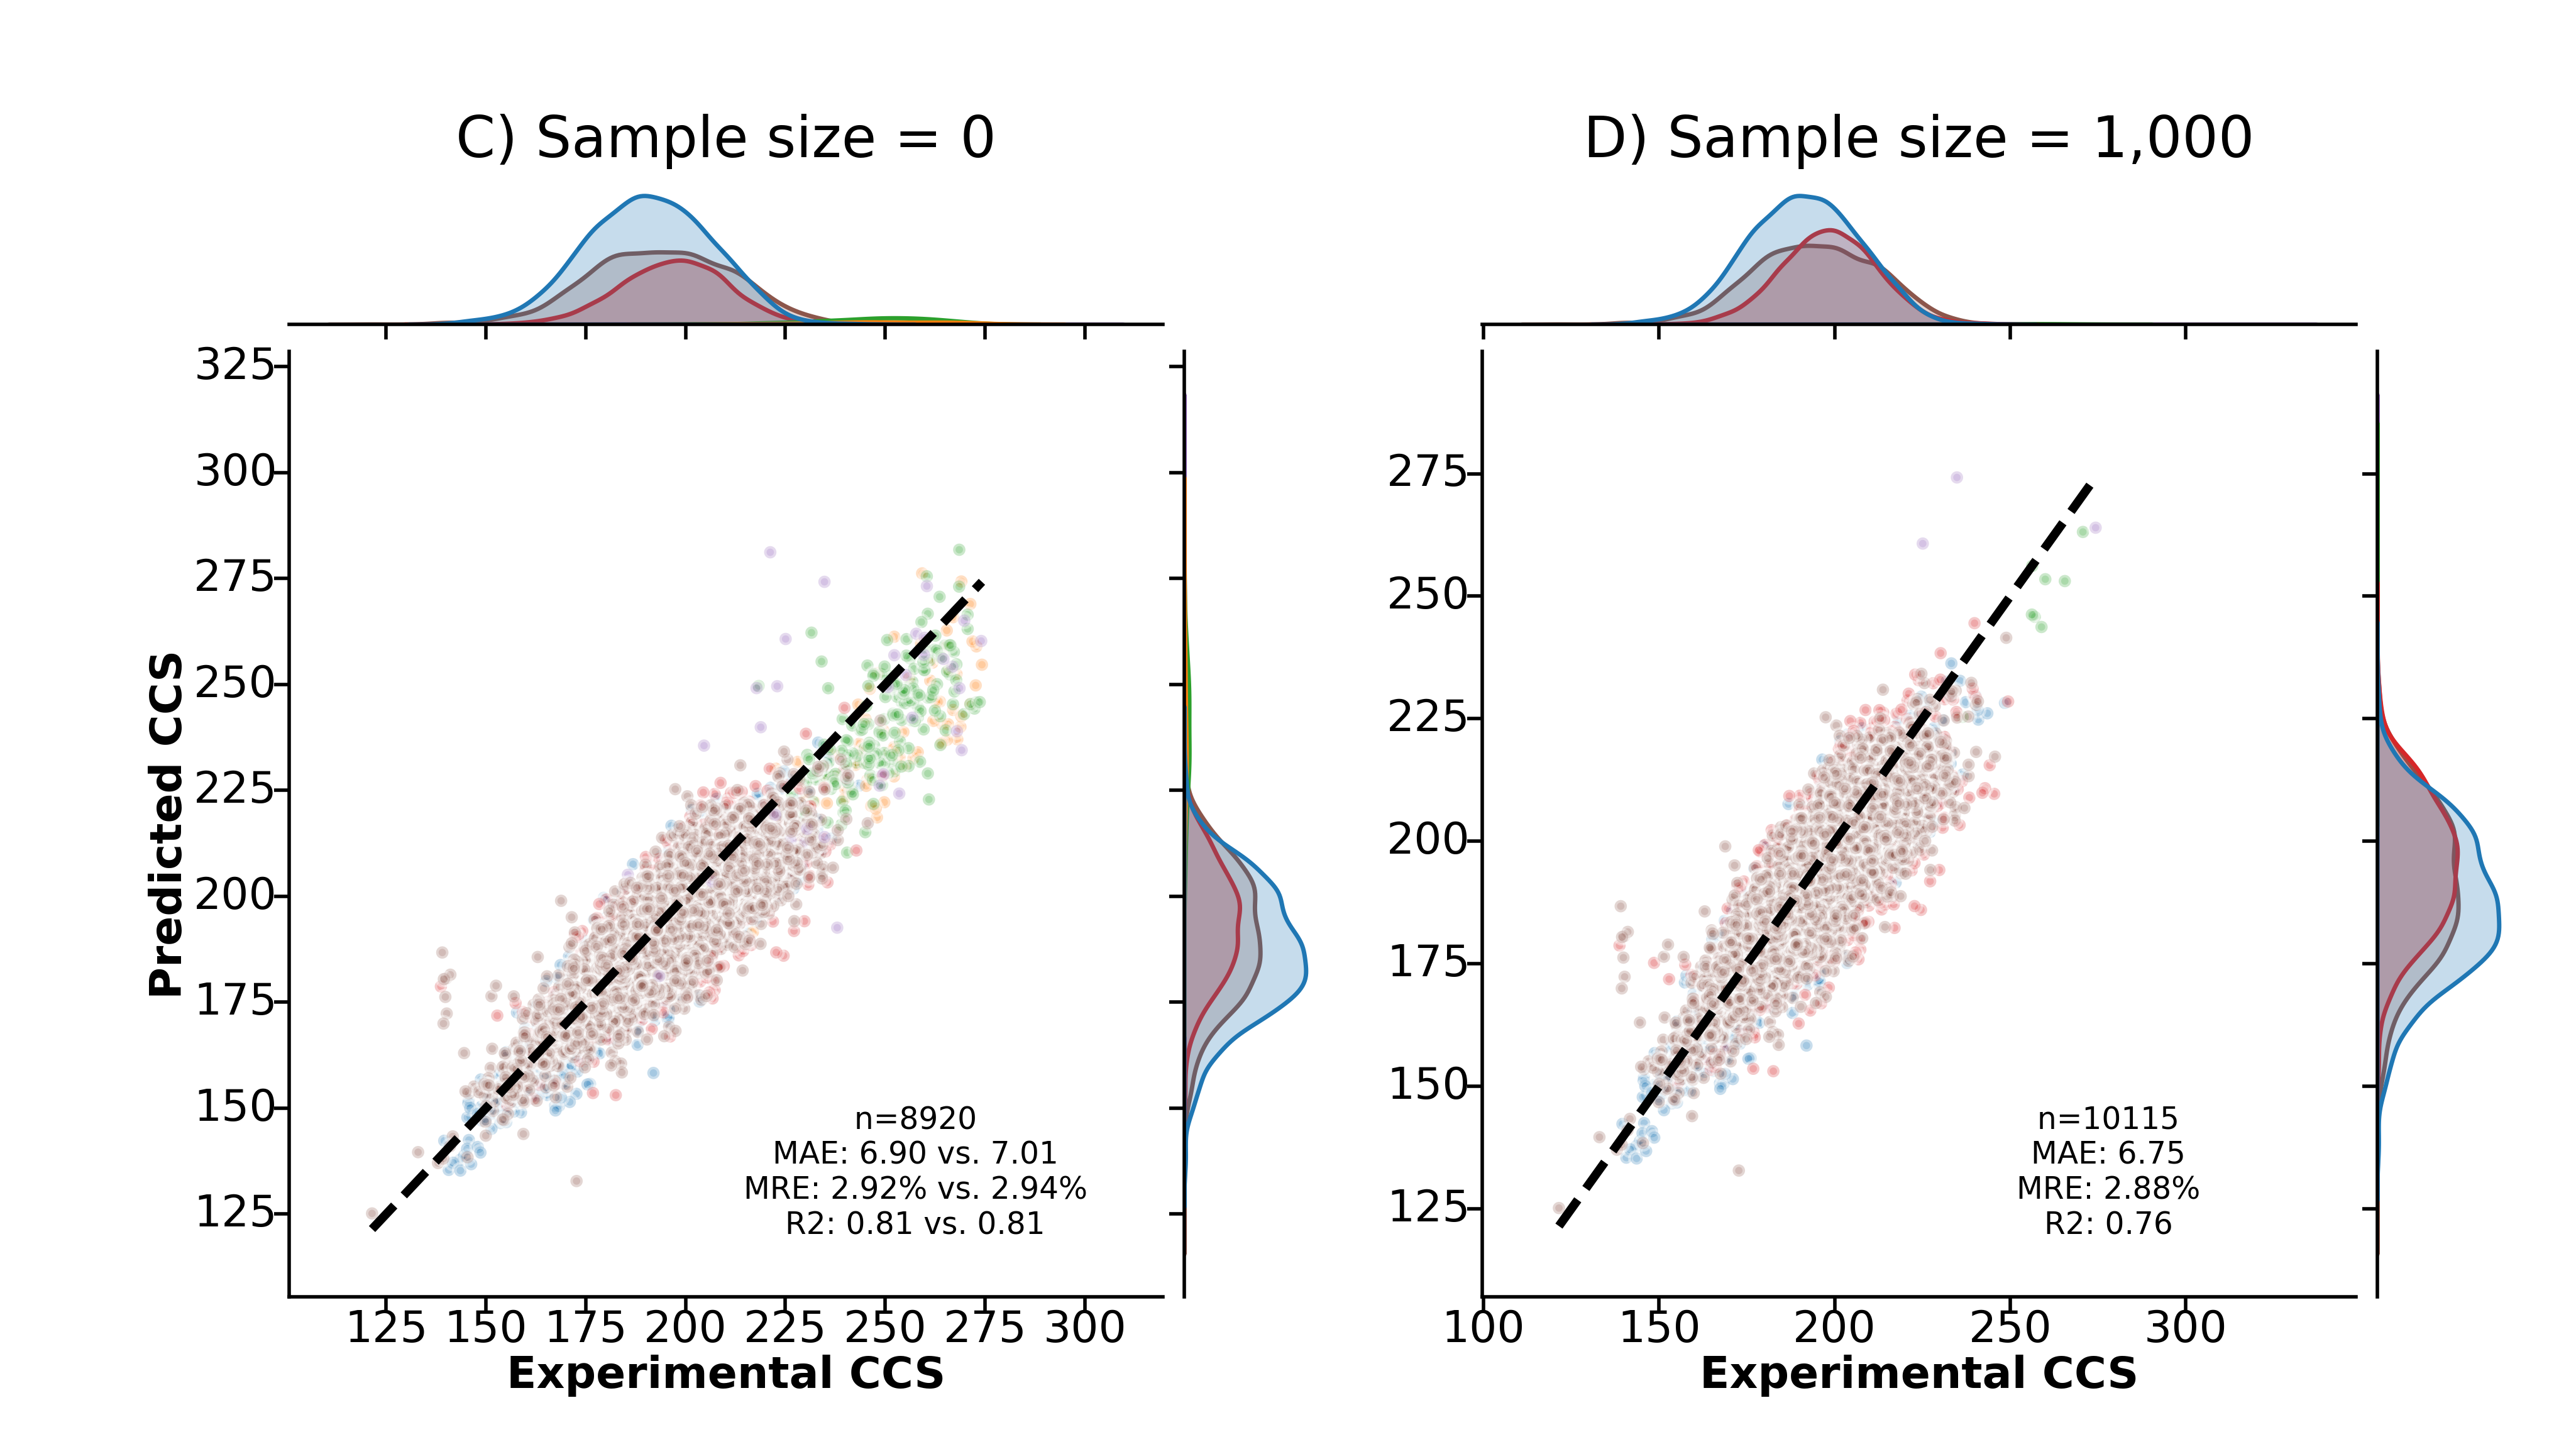

In [19]:
# Plot the distribution of the errors for the high confidence predictions using sns.joinplot

fig = plt.figure(figsize=(40, 20), dpi=400)
# gs = gridspec.GridSpec(1, 2)

palette = {
    "[M+H]+": "#1f77b4",
    "[2M+H]+": "#ff7f0e",
    "[M+Na]+": "#d62728",
    "[2M+Na]+": "#2ca02c",
    "[M-H]-": "#8c564b",
    "[2M-H]-": "#9467bd",
    "[M+K]+": "#e377c2",
    "[M+H-H2O]+": "#7f7f7f",
    "[M+NH4]+": "#bcbd22",
}

for prediction_file in high_confidence_preds:
    fig = plt.figure(figsize=(40, 20), dpi=500)
    gs = gridspec.GridSpec(1, 2)

    for i, num_sample in enumerate([0, 1000]):

        pred_df = all_high_confidence_preds[num_sample][prediction_file]

        sample_string = "{:,}".format(num_sample)
        if i == 0:
            title = f"C) Sample size = {sample_string}"
        else:
            title = f"D) Sample size = {sample_string}"

        if num_sample == 0:
            show_vs = True
        else:
            show_vs = False

        SeabornFig2Grid(
            plot_scatter(
                pred_df,
                palette,
                legend=False,  # True if i == 0 else False,
                y_label=True if i == 0 else False,
                title=title,
                original_metrics=all_original_metrics[num_sample][prediction_file],
                high_confidence_metrics=all_high_confidence_metrics[num_sample][
                    prediction_file
                ],
                show_vs=show_vs,
            ),
            fig,
            gs[i],
        )
        plt.xticks(fontsize=50)

    plt.tight_layout()
    plt.suptitle(" ", y=0, x=0)

    # save the figure
    plt.savefig("figure_5.png", dpi=400)

    plt.show()

# Look at how metrics change with sample size

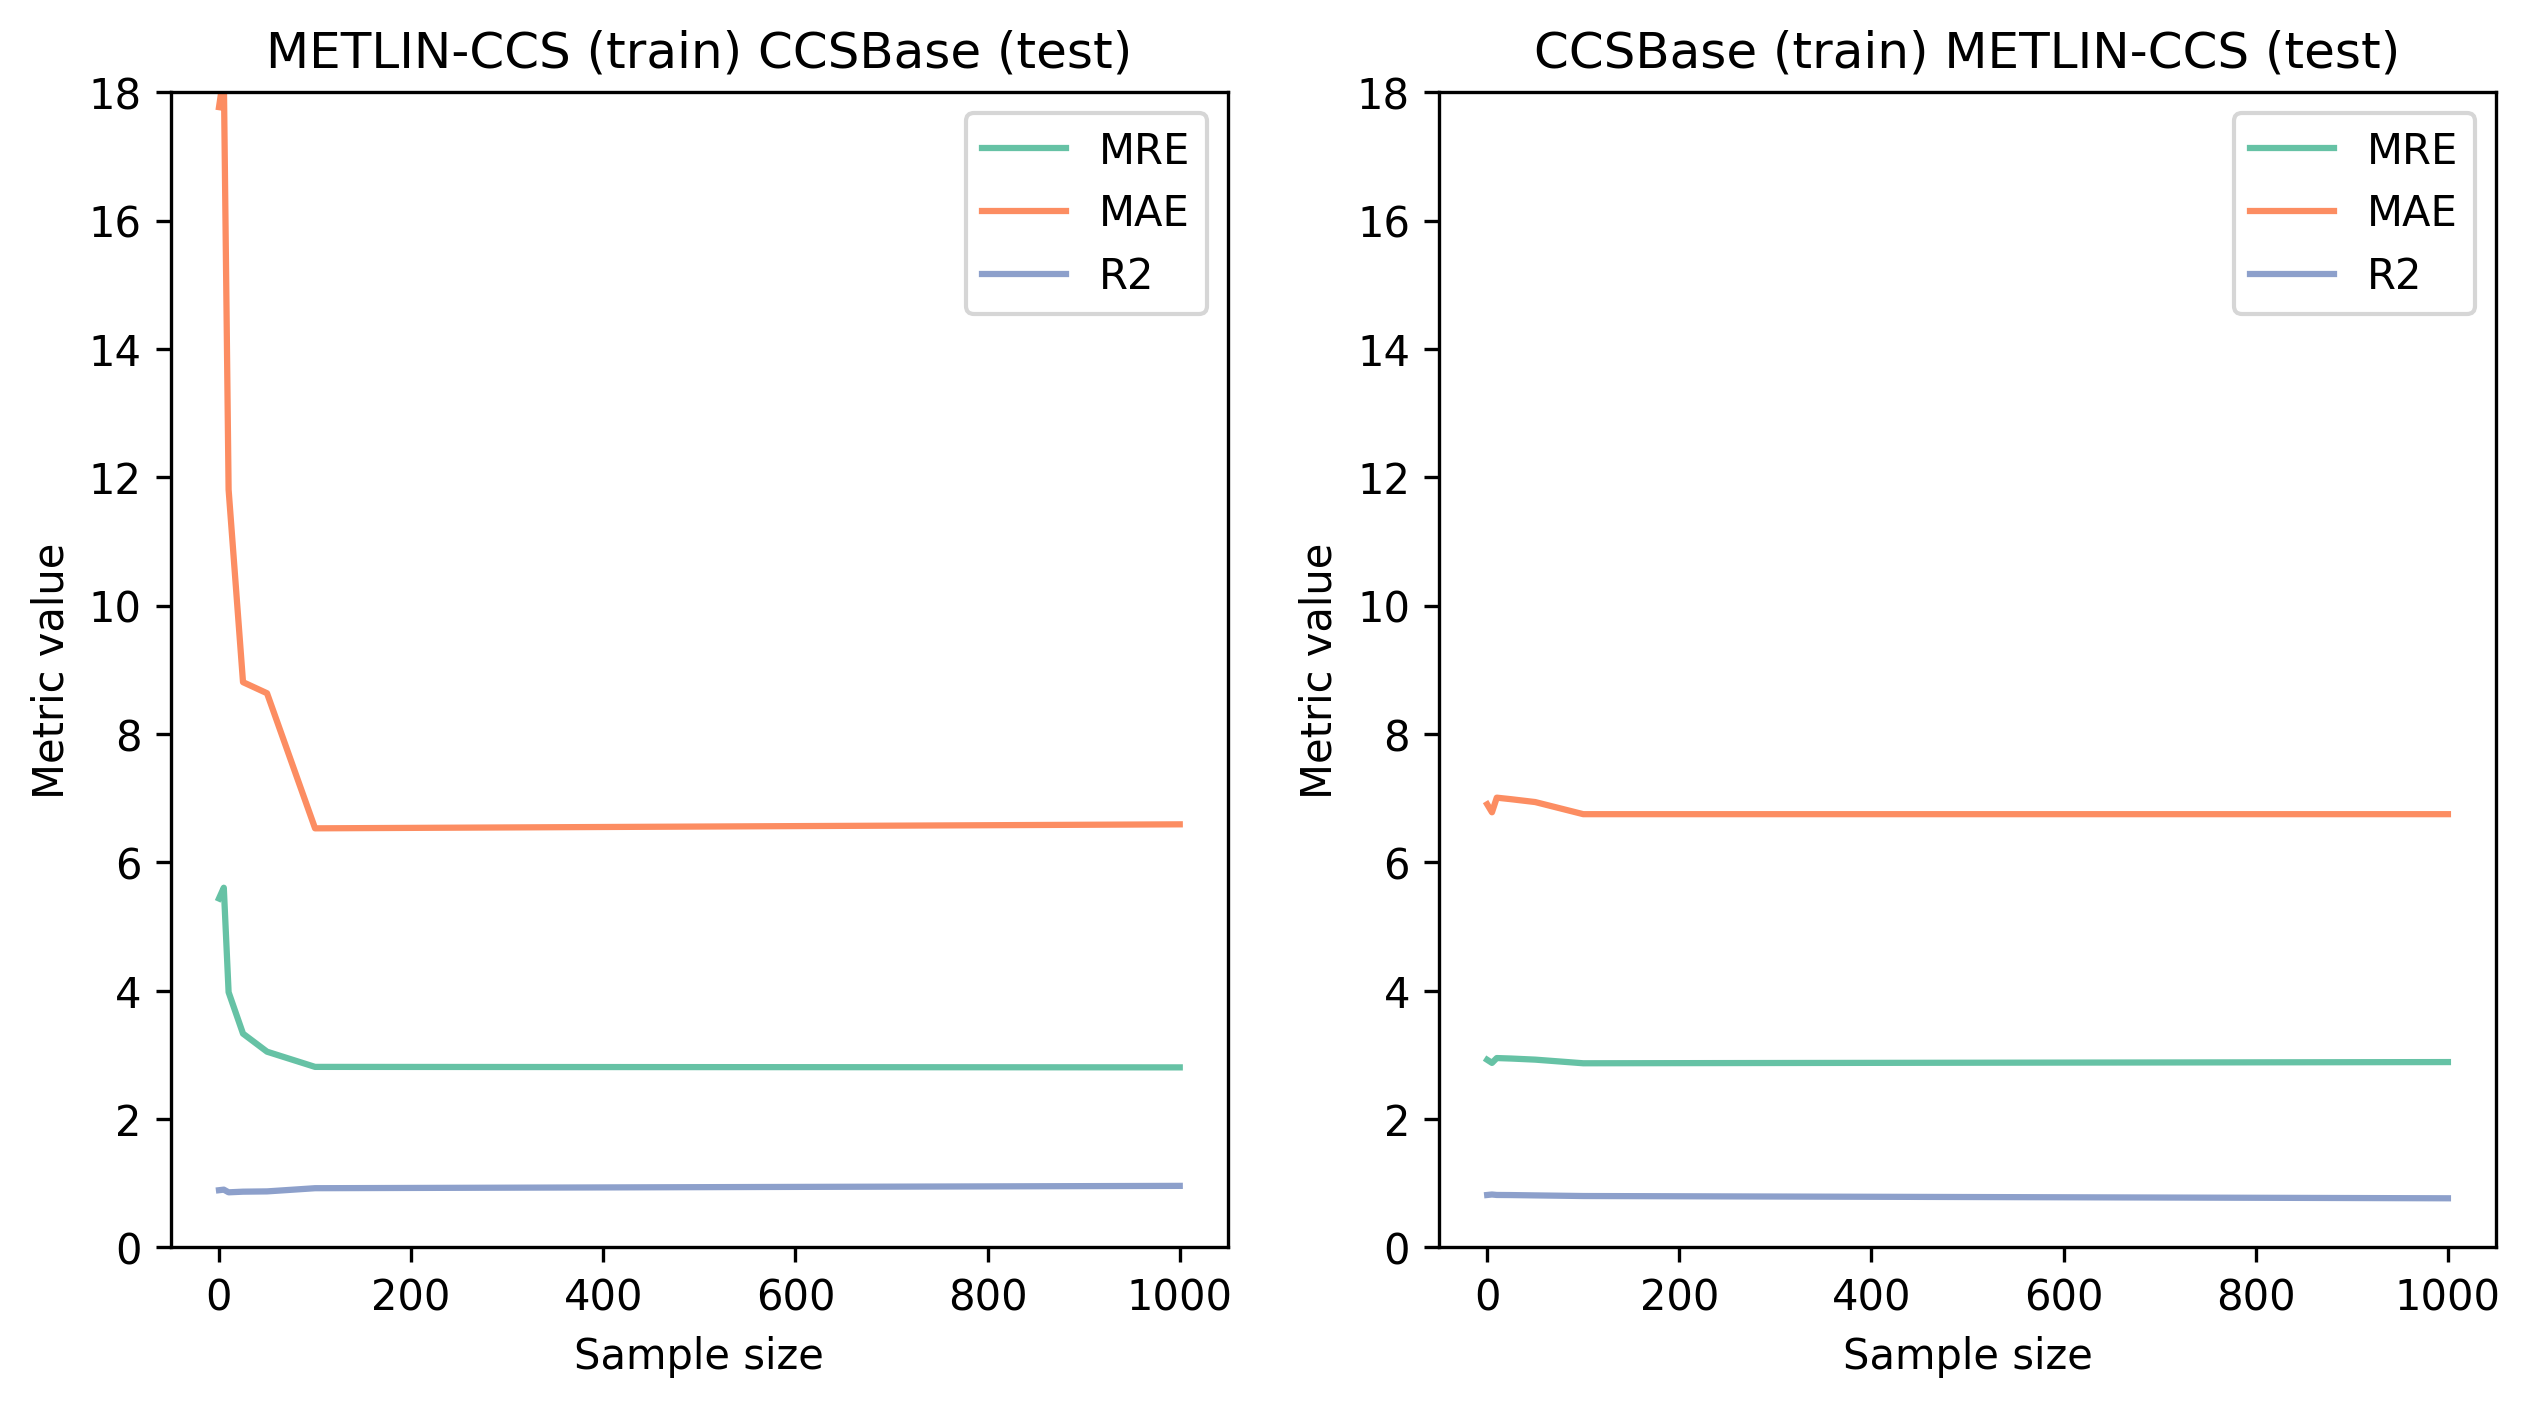

In [20]:
mre_list = []
mae_list = []
r2_list = []
rmse_list = []

metric_palette = sns.color_palette("Set2")


plt.figure(figsize=(10, 5), dpi=300)
for i, prediction_file in enumerate(all_high_confidence_metrics[sample_size]):
    mre_list = []
    mae_list = []
    r2_list = []
    rmse_list = []
    for sample_size in all_high_confidence_metrics:
        mre_list.append(
            all_high_confidence_metrics[sample_size][prediction_file]["MRE"]
        )
        mae_list.append(
            all_high_confidence_metrics[sample_size][prediction_file]["MAE"]
        )
        r2_list.append(all_high_confidence_metrics[sample_size][prediction_file]["R2"])
        rmse_list.append(
            all_high_confidence_metrics[sample_size][prediction_file]["RMSE"]
        )

    plt.subplot(1, 2, i + 1)
    plt.title(name_style[prediction_file])
    sns.lineplot(x=num_samples, y=mre_list, label="MRE", color=metric_palette[0])
    sns.lineplot(x=num_samples, y=mae_list, label="MAE", color=metric_palette[1])
    sns.lineplot(x=num_samples, y=r2_list, label="R2", color=metric_palette[2])
    plt.ylim((0, 18))
    plt.legend()
    plt.xlabel("Sample size")
    plt.ylabel("Metric value")
plt.show()

# Look at the amount of the dataset that is retained after thresholding

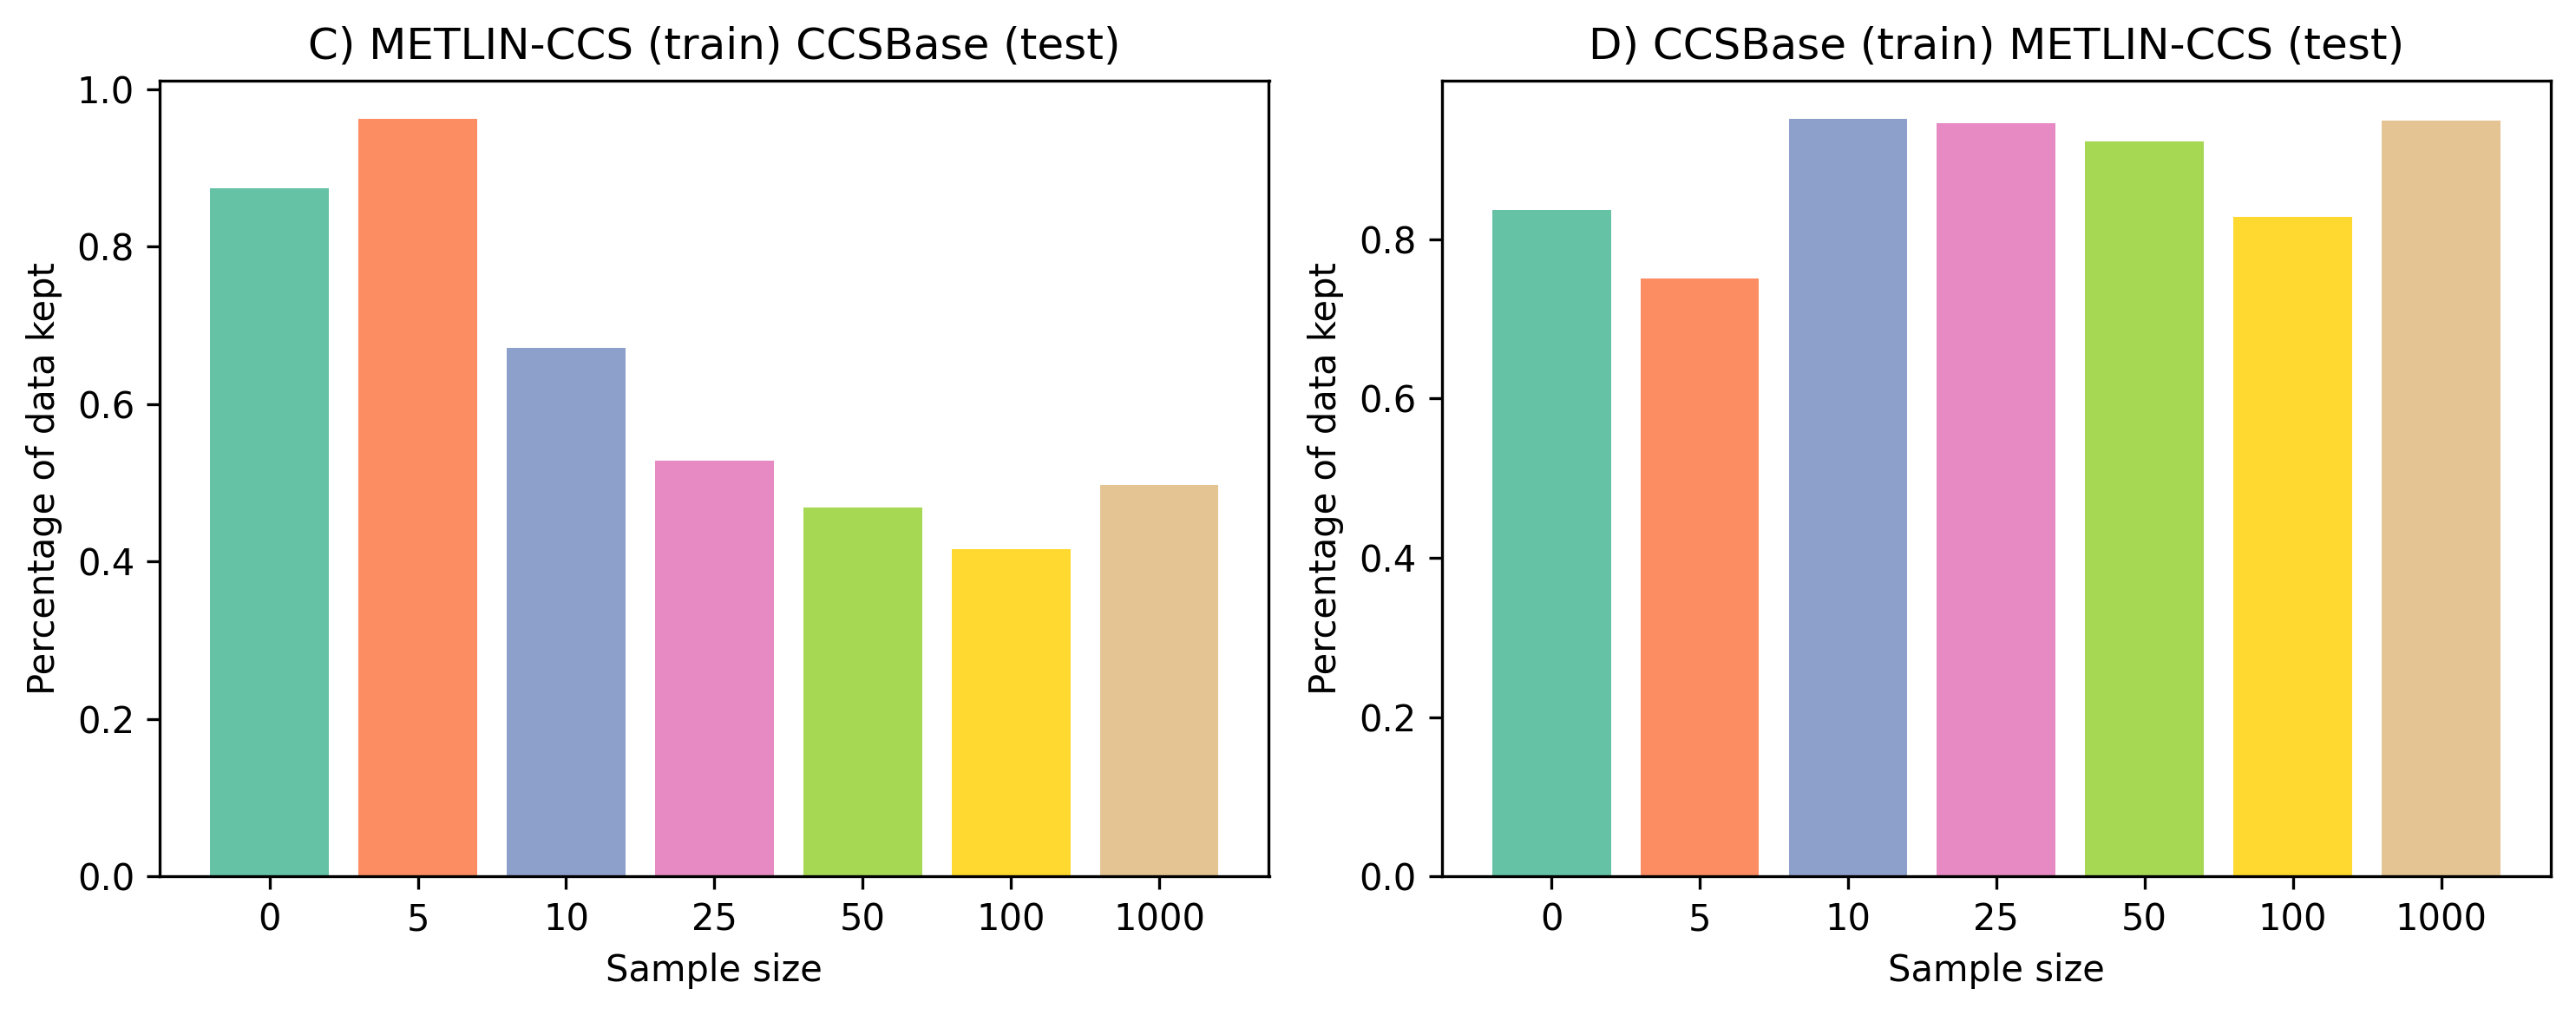

In [21]:
import numpy as np

metric_palette = sns.color_palette("Set2")
colors = [metric_palette[i] for i in range(7)]
plt.figure(figsize=(10, 4), dpi=300)

for j, prediction_file in enumerate(all_high_confidence_preds[0]):
    data_percents = {}
    for num_sample in num_samples:
        pred_df = all_confidence_preds[num_sample][prediction_file]
        current_threshold = all_thresholds_df[num_sample][prediction_file]

        percent_data_kept = (
            pred_df[pred_df.confs >= current_threshold].shape[0] / pred_df.shape[0]
        )
        data_percents[num_sample] = percent_data_kept

    plt.subplot(1, 2, j + 1)
    plt.bar(np.arange(len(data_percents)), data_percents.values(), color=colors)
    plt.xticks(np.arange(len(data_percents)), data_percents.keys())
    plt.xlabel("Sample size")
    plt.ylabel("Percentage of data kept")
    if j == 0:
        plt.title(f"C) {name_style[prediction_file]}")
    else:
        plt.title(f"D) {name_style[prediction_file]}")
plt.tight_layout()
plt.show()